The goal is to predict traffic flow for multiple steps ahead for all the highways in Belgium¶

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import pandas.testing as tm
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from tensorflow.keras.layers import LSTM, Dense, Dropout, concatenate, Activation
from keras.layers import Conv1D, BatchNormalization, GlobalMaxPool1D, Permute, Dropout, Input
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import os # accessing directory structure

%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
mpl.rcParams['figure.figsize'] = 25,5
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.linewidth'] = 1.5

In [2]:
# check GPU
tf.test.gpu_device_name()
!/opt/bin/nvidia-smi

Sun May  8 06:55:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    56W / 149W |    145MiB / 11441MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
from numpy.random import seed

# Reproducability
def set_seed(seed=31415):
    
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
set_seed(31415)

In [6]:
number = int(input("Which dataset do you want to use? \nInput 1 to use 'Bel_30_min_2019_4features.csv' \nInput 2 to use 'Bel_30_min_2019_processed.csv' "))

Which dataset do you want to use? 
Input 1 to use 'Bel_30_min_2019_4features.csv' 
Input 2 to use 'Bel_30_min_2019_processed.csv' 2


In [7]:
# get data 
output_result_name = '9features_pred_results'
if number== 1:
    output_result_name = '4features_pred_results'
    df=pd.read_csv("/content/drive/My Drive/BD10/Bel_30_min_2019_4features.csv",parse_dates=['Datetime'],index_col="Datetime")
    f_cols1 = ['Hour_x','Hour_y','DayOfWeek','WorkingDays']
elif number== 2:
    df=pd.read_csv("/content/drive/My Drive/BD10/Bel_30_min_2019_processed.csv",parse_dates=['Datetime'],index_col="Datetime")
    f_cols1 = ['Hour','Minute','Second','Date','Month','Year','Day_Of_Week','Weekdays_Or_Weekend','Day_Or_Night']
else:
    print("Please input a valid number")

df.head()

,Sum_Traffic_Count,Day_Of_Week,Date,Month,Year,Hour,Minute,Second,Day_Or_Night,Weekdays_Or_Weekend
Datetime,,,,,,,,,,
2019-01-01 00:00:00,2391,3,1,1,2019,0,0,0,1,0
2019-01-01 00:30:00,2386,3,1,1,2019,0,30,0,1,0
2019-01-01 01:00:00,2428,3,1,1,2019,1,0,0,1,0
2019-01-01 01:30:00,2617,3,1,1,2019,1,30,0,1,0
2019-01-01 02:00:00,2068,3,1,1,2019,2,0,0,1,0


In [8]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 2832 rows and 10 columns


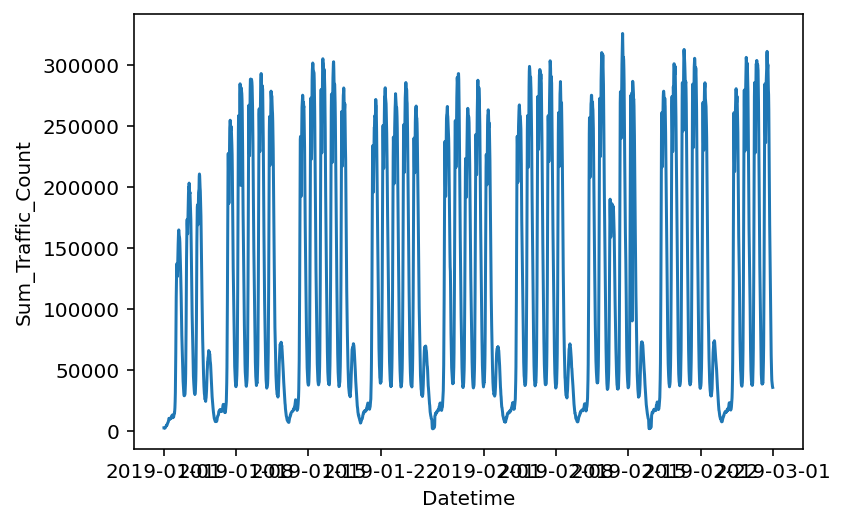

In [8]:
sns.lineplot(x=df.index, y="Sum_Traffic_Count", data=df)

## Data preparation

In [9]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

2265 567


# normalize data

In [10]:
# data normalization
from sklearn.preprocessing import RobustScaler

f_transformer1 = RobustScaler()
result_transformer = RobustScaler()

f_transformer1 = f_transformer1.fit(train[f_cols1].to_numpy())
result_transformer = result_transformer.fit(train[['Sum_Traffic_Count']])

train.loc[:, f_cols1] = f_transformer1.transform(train[f_cols1].to_numpy())
train['Sum_Traffic_Count'] = result_transformer.transform(train[['Sum_Traffic_Count']])

test.loc[:, f_cols1] = f_transformer1.transform(test[f_cols1].to_numpy())
test['Sum_Traffic_Count'] = result_transformer.transform(test[['Sum_Traffic_Count']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [11]:
def create_dataset(X, Y, time_steps=1):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        Ys.append(Y.iloc[i + time_steps])
    return np.array(Xs), np.array(Ys)

# reshape training data

In [12]:
TIME_STEPS = 24
x_train, y_train = create_dataset(train, train.Sum_Traffic_Count, time_steps = TIME_STEPS)
x_test, y_test = create_dataset(test, test.Sum_Traffic_Count, time_steps = TIME_STEPS)

In [13]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2241, 24, 10) (2241,)
(543, 24, 10) (543,)


# build model

In [ ]:
from keras.layers import MaxPooling1D
def LSTM_FCN():
    input = Input(shape=(x_test.shape[1], x_test.shape[2]))

    x = LSTM(50, return_sequences=True)(input)
    x = LSTM(50)(x)
    x = Dropout(0.8)(x)
    x = Dense(1)(x)

    y = Permute((2, 1))(input) # None, 10, 30 -> None, 1, 1
    y = Conv1D(64, 8, padding='same', kernel_initializer='he_uniform')(y) # None, 10, 128
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(64, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalMaxPool1D()(y)
    x = concatenate([x, y])

    out = Dense(1, activation='linear')(x)

    model = Model(inputs=input, outputs=out)
    model.compile(loss='mae', optimizer='adam',metrics=['mse'])

    return model

In [ ]:
model = LSTM_FCN()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 5)]      0           []                               
                                                                                                  
 permute (Permute)              (None, 5, 24)        0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 5, 64)        12352       ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 5, 64)       256         ['conv1d[0][0]']                 
 alization)                                                                                   

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

epochs_value = 200
batch_size_value = 64

history = model.fit(
    x_train, y_train, 
    epochs=epochs_value, 
    batch_size=batch_size_value, 
    validation_split=0,
    shuffle=False
)

Epoch 1/200
36/36 [==============================] - 22s 30ms/step - loss: 0.8606 - mse: 1.3271
Epoch 2/200
36/36 [==============================] - 1s 21ms/step - loss: 0.4965 - mse: 0.4250
Epoch 3/200
36/36 [==============================] - 1s 21ms/step - loss: 0.3683 - mse: 0.2233
Epoch 4/200
36/36 [==============================] - 1s 21ms/step - loss: 0.3129 - mse: 0.1690
Epoch 5/200
36/36 [==============================] - 1s 21ms/step - loss: 0.2468 - mse: 0.0956
Epoch 6/200
36/36 [==============================] - 1s 22ms/step - loss: 0.2181 - mse: 0.0760
Epoch 7/200
36/36 [==============================] - 1s 21ms/step - loss: 0.2328 - mse: 0.0860
Epoch 8/200
36/36 [==============================] - 1s 21ms/step - loss: 0.1920 - mse: 0.0597
Epoch 9/200
36/36 [==============================] - 1s 22ms/step - loss: 0.1911 - mse: 0.0620
Epoch 10/200
36/36 [==============================] - 1s 21ms/step - loss: 0.2491 - mse: 0.0937
Epoch 11/200
36/36 [============================

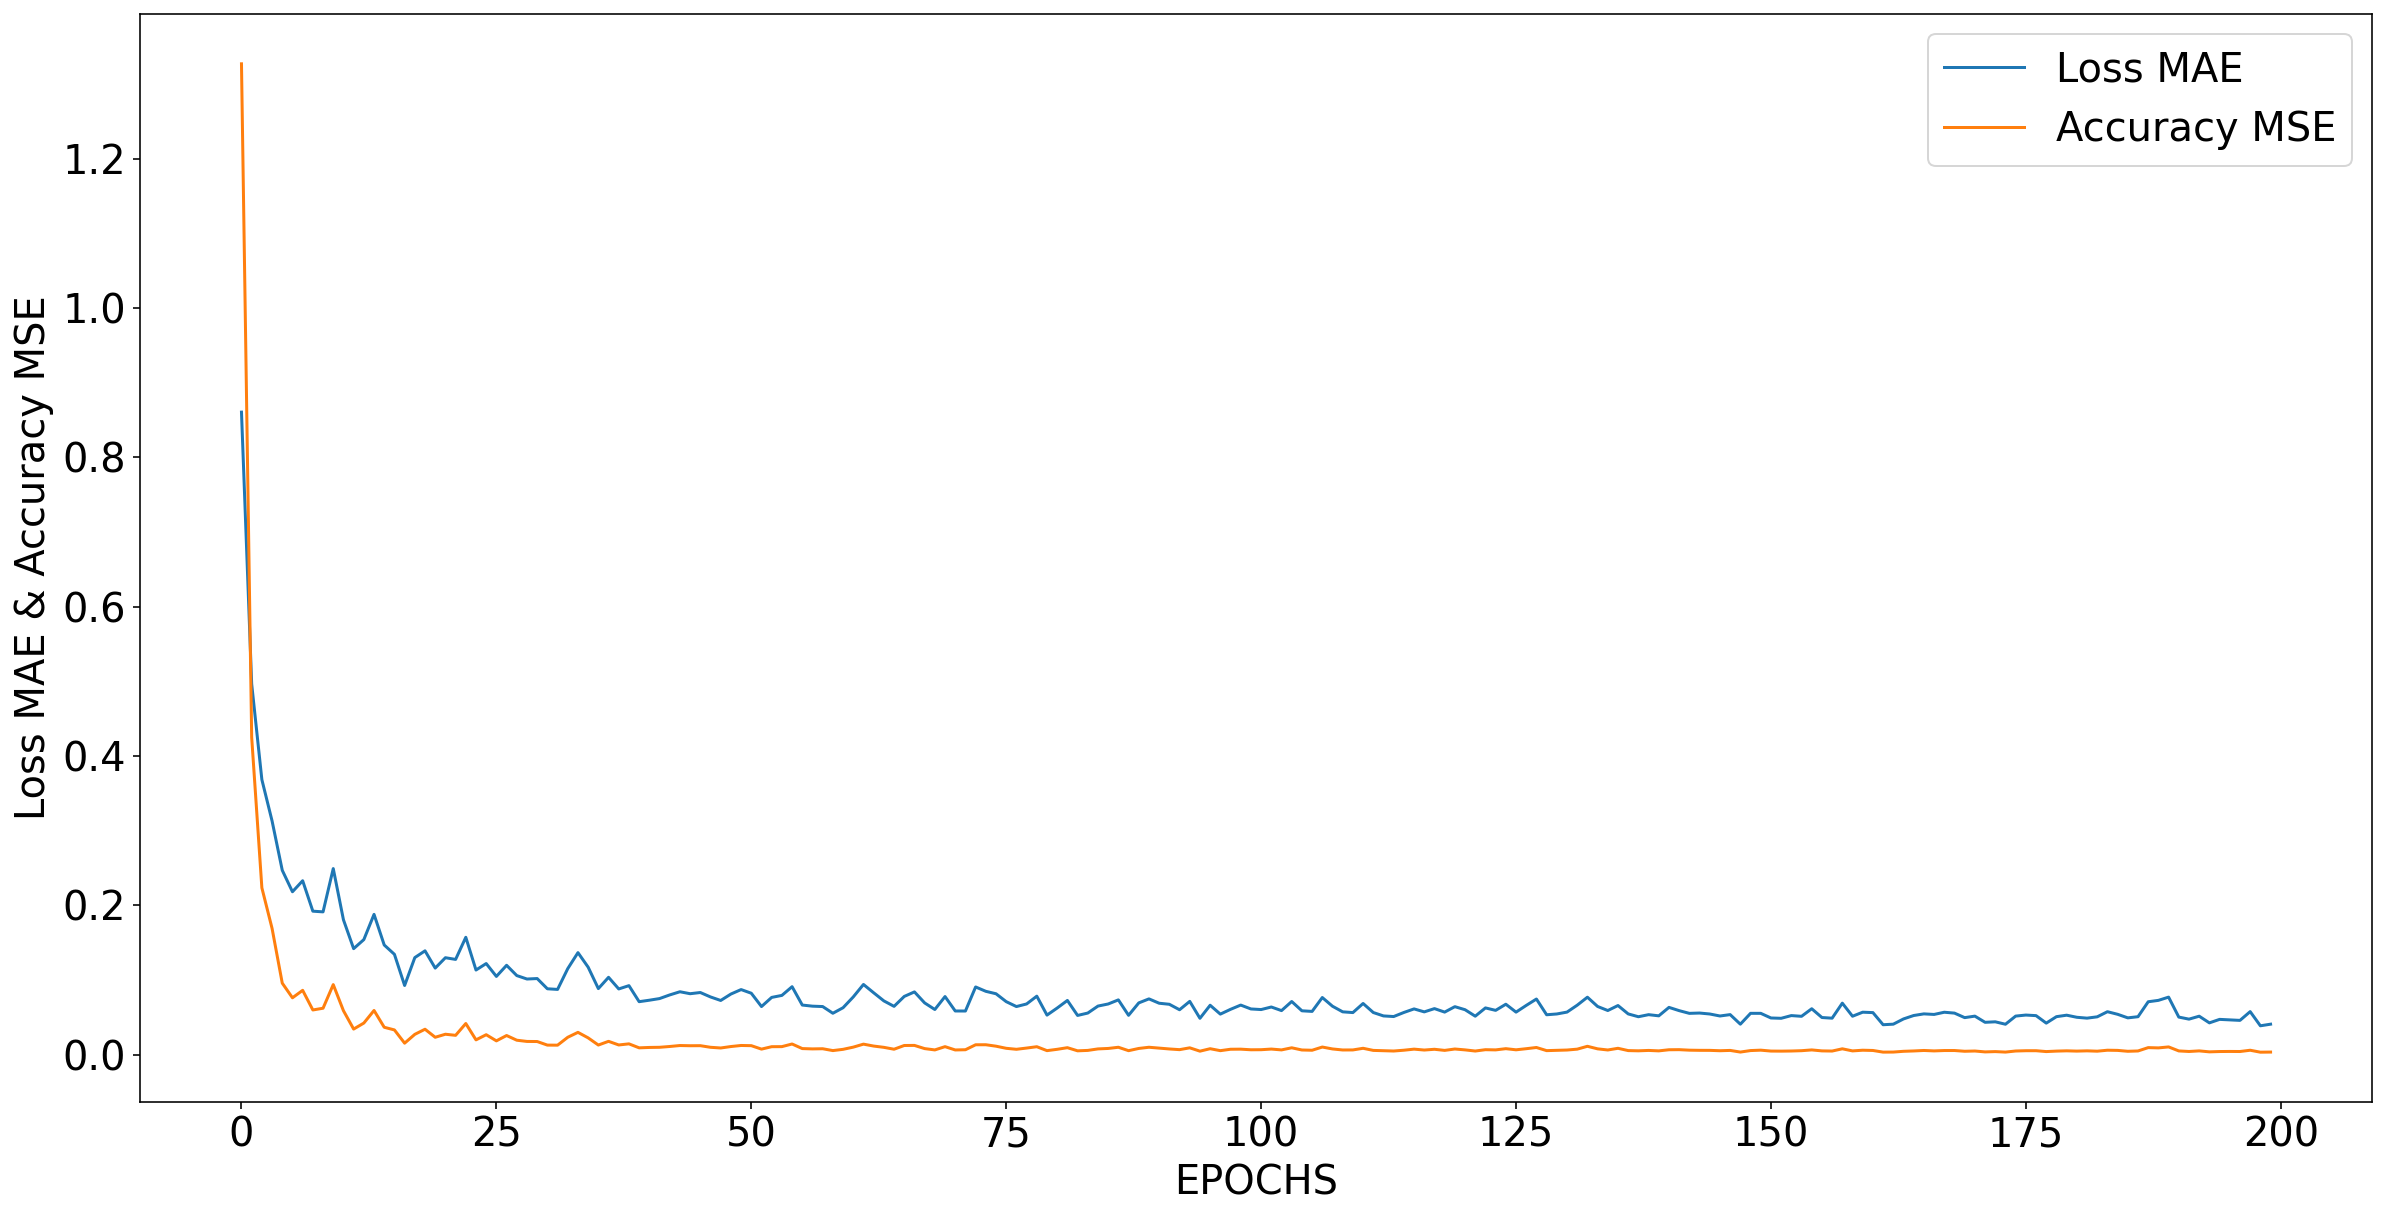

In [ ]:
# plot loss figure
model.save('/content/drive/My Drive/BD10/LSTM_FCN_' + output_result_name + '.h5')
plt.plot(history.history['loss'], label='Loss MAE')
plt.plot(history.history['mse'], label='Accuracy MSE')
plt.ylabel('Loss MAE & Accuracy MSE')
plt.xlabel('EPOCHS')
plt.legend()

In [14]:
from tensorflow.keras.models import load_model

model=load_model('/content/drive/My Drive/BD10/LSTM_FCN_' + output_result_name + '.h5')
y_pred = model.predict(x_test)

In [15]:
# data denormalization
y_train_inv = result_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = result_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = result_transformer.inverse_transform(y_pred)
# print the accuracy and MAE value
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
pred=y_pred_inv.flatten()
real=y_test_inv.flatten()

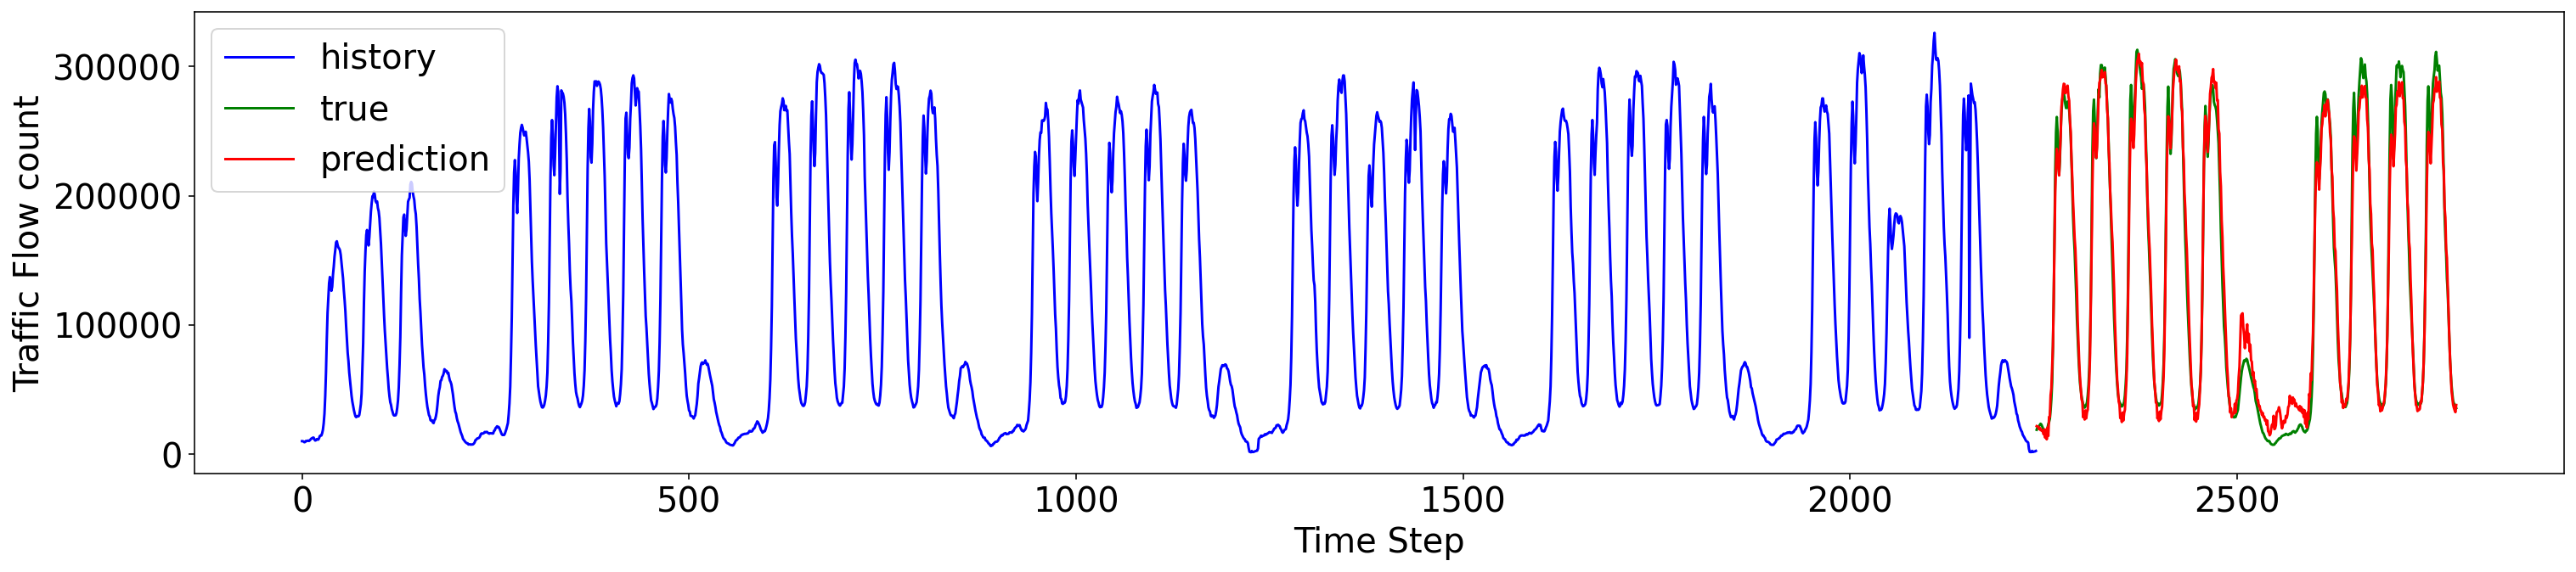

In [16]:
# Plot the predicted value, true value and history
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'b', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), real, color='g', label="true",)
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), pred, 'r', label="prediction")
plt.ylabel('Traffic Flow count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

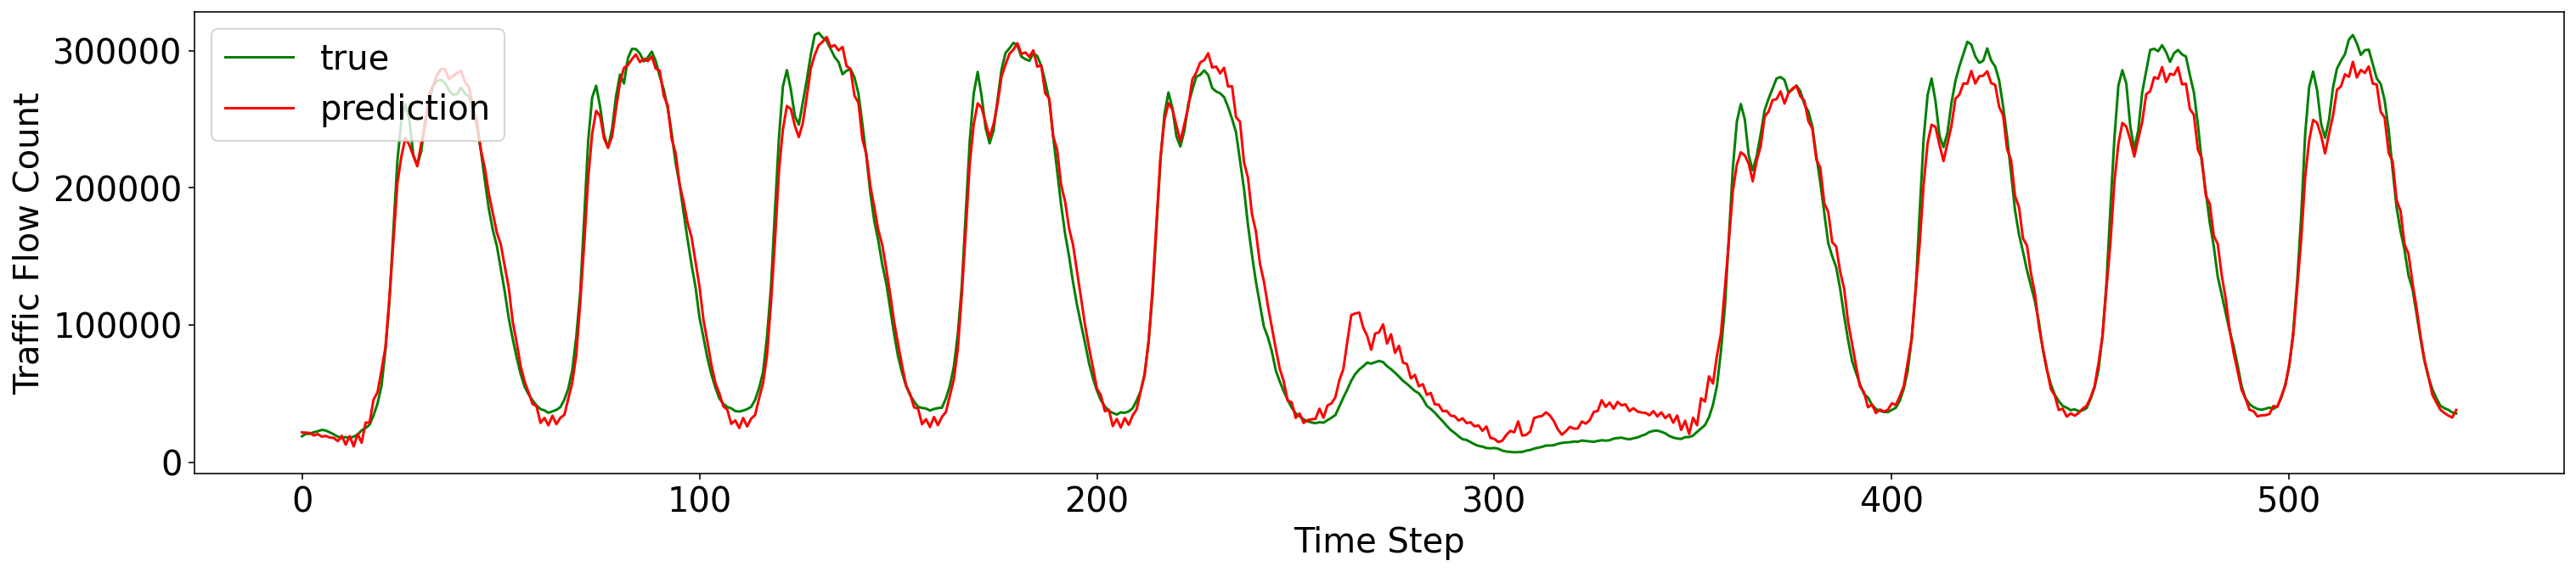

In [17]:
# Plot the predicted value and true value.
mpl.rcParams['figure.figsize'] = 25,5
plt.plot(real, color='g', label="true")
plt.plot(pred, 'r', label="prediction")
plt.ylabel('Traffic Flow Count')
plt.xlabel('Time Step')
plt.legend( loc='upper left')
plt.show();

In [ ]:
import pickle

# Saving the objects:
with open('/content/drive/My Drive/BD10/LSTM_FCN_' + output_result_name + '.pkl', 'wb') as f:
    pickle.dump([real,pred], f)